# Digital Signal and Image Management - Image retrieval
Master's Degree in Data Science (A.Y. 2021/2022)

Autori: Silvia Ranieri, 
Raffaele Moretti,
Mattia Boller


# Librerie

In [39]:
# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# Data import libraries
import zipfile
import os
from shutil import copyfile

import numpy as np
import time
import re

from matplotlib import pyplot as plt

# KDTree creation and saving
from sklearn.neighbors import KDTree
import joblib

# OpenCV
import cv2 as cv

In [40]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [41]:
copyfile('gdrive/MyDrive/PROGETTO DIGITAL IMAGE/Dataset/thumbnails_features_deduped_publish.zip', 'thumbnails.zip')
with zipfile.ZipFile('thumbnails.zip', 'r') as zip:
    zip.extractall()
    zip.close()

## Autoencoder approach

### Load images and extract faces

In [ ]:
# Extract face from a photo
def face_extractor(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    faceCascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")
    detect_faces = faceCascade.detectMultiScale(gray)
    resized_face=[]
    if len(detect_faces)>0:
        # Find the face by looking at the size of detections (choose the largest one)
        # Sometimes opencv detect wrong faces and usually are smaller portion of the original image in respect to the true face
        face_index = np.argmax(detect_faces[:,2]) 
        x, y, w, h = detect_faces[face_index]
        face = image[y:y + h, x:x + w]
        resized_face = cv.resize(face, dsize=(128, 128), interpolation=cv.INTER_CUBIC)
    return resized_face

In [ ]:
# Load photos for training the autoencoder and extract faces
def load_train_data(max_images=3):
  dir = 'thumbnails_features_deduped_publish'
  train_faces = []
  for person in sorted(os.listdir(dir)):
    for fi,f in enumerate(sorted(os.listdir(dir + '/' + person))):
      if f.endswith('.jpg') and fi<max_images:
        image = cv.imread(dir + '/' + person + '/' + f)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        face = face_extractor(image)
        if len(face)!=0:
          train_faces.append(face)
  
  # Normalize values between 0 and 1
  train_faces = np.array(train_faces)/255.0
  return train_faces

In [ ]:
# Load some photos per person
train_faces = load_train_data(max_images=3)

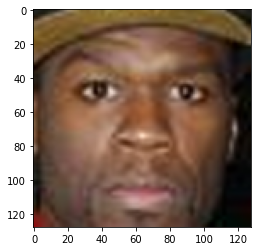

In [ ]:
plt.imshow(train_faces[0])

### Build autoencoder

In [ ]:
input = layers.Input(shape=(128, 128, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(8, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, decoded)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

# Encoder
encoder = Model(input, encoded)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 8)         1160  

In [ ]:
autoencoder.fit(x=train_faces, y=train_faces, epochs=30, batch_size=64)

Epoch 1/30
67/67 [==============================] - 20s 129ms/step - loss: 0.0586
Epoch 2/30
67/67 [==============================] - 8s 124ms/step - loss: 0.0167
Epoch 3/30
67/67 [==============================] - 8s 123ms/step - loss: 0.0096
Epoch 4/30
67/67 [==============================] - 8s 124ms/step - loss: 0.0070
Epoch 5/30
67/67 [==============================] - 8s 123ms/step - loss: 0.0055
Epoch 6/30
67/67 [==============================] - 8s 123ms/step - loss: 0.0048
Epoch 7/30
67/67 [==============================] - 8s 123ms/step - loss: 0.0046
Epoch 8/30
67/67 [==============================] - 8s 123ms/step - loss: 0.0043
Epoch 9/30
67/67 [==============================] - 8s 123ms/step - loss: 0.0041
Epoch 10/30
67/67 [==============================] - 8s 123ms/step - loss: 0.0040
Epoch 11/30
67/67 [==============================] - 8s 123ms/step - loss: 0.0038
Epoch 12/30
67/67 [==============================] - 8s 123ms/step - loss: 0.0037
Epoch 13/30
67/67 [=====

In [ ]:
encoder.save('gdrive/MyDrive/PROGETTO DIGITAL IMAGE/Image_Retrieval/encoder.h5')

### Test with image from training set

Text(0.5, 1.0, 'Encoded + Decoded')

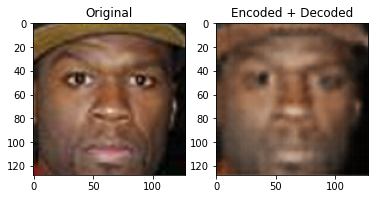

In [ ]:
pred = autoencoder.predict(np.expand_dims(train_faces[0], axis=0))

# Plot images
plt.subplot(1, 2, 1); plt.imshow(train_faces[0]); plt.title('Original')
plt.subplot(1, 2, 2); plt.imshow(pred[0]); plt.title('Encoded + Decoded')

### Test with image not used for training

Text(0.5, 1.0, 'Encoded + Decoded')

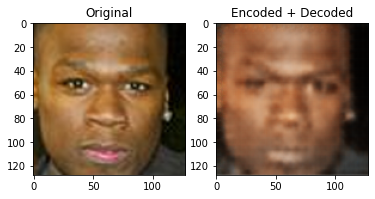

In [ ]:
# Load image
image = cv.imread('thumbnails_features_deduped_publish/50 cent/105.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
face = face_extractor(image)
face = np.array(face)/255.0

# Encode and decode image
pred = autoencoder.predict(np.expand_dims(face, axis=0))

# Plot images
plt.subplot(1, 2, 1); plt.imshow(face); plt.title('Original')
plt.subplot(1, 2, 2); plt.imshow(pred[0]); plt.title('Encoded + Decoded')

### Compute photos features and build search tree

In [ ]:
encoder = keras.models.load_model('gdrive/MyDrive/PROGETTO DIGITAL IMAGE/Image_Retrieval/encoder.h5')

In [ ]:
# Dummy feature
def identity(image):
    image = cv.imread(image)
    return np.reshape(image, (1,-1))

# Data loader
def load_data(feature_extractor=identity, max_images=3):
  dir = 'thumbnails_features_deduped_publish'

  paths = []
  features = []

  for person in sorted(os.listdir(dir)):
    for fi,f in enumerate(sorted(os.listdir(dir + '/' + person))):
      if f.endswith('.jpg') and fi<max_images:
        cur_path = dir + '/' + person + '/' + f
        # Load file and extract features
        cur_features = feature_extractor(cur_path)
        if len(cur_features)>0:
          paths.append(cur_path)
          features.append(cur_features)

  features = np.array(features)
  return paths, features

# Encoder feature extractor
def encoder_features(image):
  image = cv.imread(image)
  image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  face = face_extractor(image)
  enc = []
  if len(face)!=0:
    face = np.array(face)/255.0
    # Encode and decode image
    pred = encoder.predict(np.expand_dims(face, axis=0))
    enc =  np.reshape(pred, (1,-1))[0]
  return enc

In [ ]:
# Extract features
t0 = time.time()
paths, features = load_data(encoder_features, max_images=100)
print("Data loading and feature extraction completed in %0.3f seconds." % (time.time() - t0))

Data loading and feature extraction completed in 9370.596 seconds.


In [ ]:
print("Extracted %0.0f faces." % (len(paths)))

Extracted 99148 faces.


In [ ]:
# Build tree
tree = KDTree(features)

In [ ]:
# Saving the search tree
joblib.dump(tree, 'gdrive/MyDrive/PROGETTO DIGITAL IMAGE/Image_Retrieval/kdtree.joblib')

['gdrive/MyDrive/PROGETTO DIGITAL IMAGE/Image_Retrieval/kdtree.joblib']

In [ ]:
# Saving paths list
with open("gdrive/MyDrive/PROGETTO DIGITAL IMAGE/Image_Retrieval/paths.txt", "w") as f:
    for path in paths:
        f.write(str(path) +"\n")

### Find the 10 most similar faces to the query face

In [42]:
# Loading the search tree
tree = joblib.load('gdrive/MyDrive/PROGETTO DIGITAL IMAGE/Image_Retrieval/kdtree.joblib')

In [43]:
# Loading paths list
paths = []
with open("gdrive/MyDrive/PROGETTO DIGITAL IMAGE/Image_Retrieval/paths.txt", "r") as f:
  for line in f:
    paths.append(str(line.strip()))

#### Raffaele

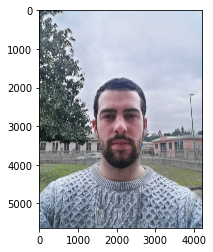

In [52]:
# Query image
query = cv.imread('/content/gdrive/MyDrive/PROGETTO DIGITAL IMAGE/Progetto_DSIM_MattiaBoller_RaffaeleMoretti_SilviaRanieri/Face_Recognition/Faces/Raffaele/IMG_20220103_164836.jpg')
query = cv.cvtColor(query, cv.COLOR_BGR2RGB)
plt.imshow(query)

In [53]:
# Compute query image features
query_features = encoder_features('/content/gdrive/MyDrive/PROGETTO DIGITAL IMAGE/Progetto_DSIM_MattiaBoller_RaffaeleMoretti_SilviaRanieri/Face_Recognition/Faces/Raffaele/IMG_20220103_164836.jpg')

In [54]:
# Search
t0 = time.time()
dist, ind = tree.query(np.expand_dims(query_features, axis=0), k=10)
print("Query time: %0.3f seconds." % (time.time() - t0))

Query time: 0.397 seconds.


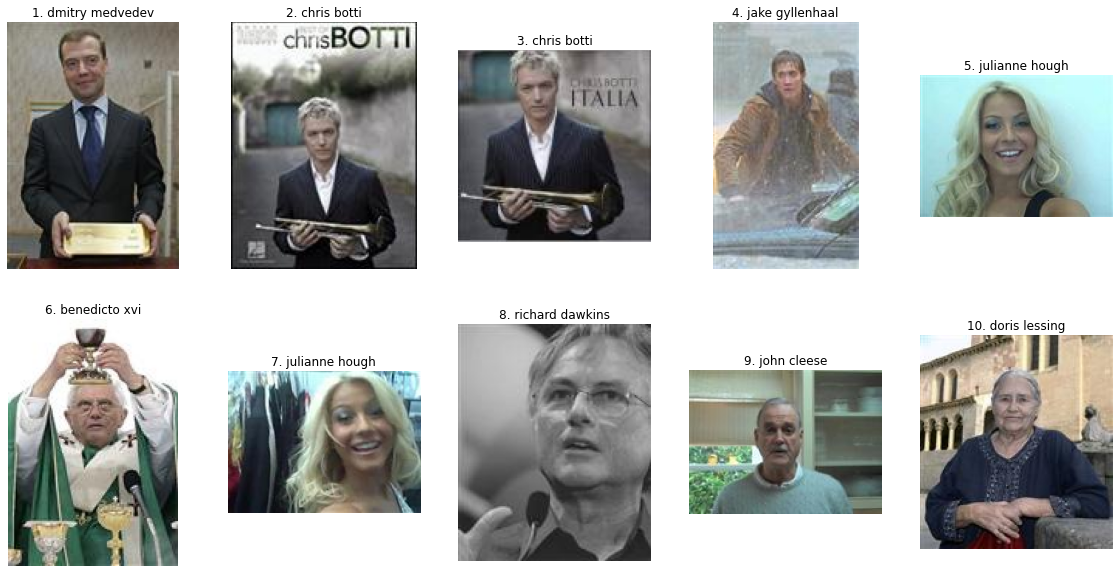

In [55]:
# Show 10 most similar faces
plt.figure(figsize=(20, 10))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(cv.cvtColor((cv.imread(paths[ind[0][i]])), cv.COLOR_BGR2RGB))
  plt.title(str(i+1) + '. ' + re.findall('\/(.*?)\/', paths[ind[0][i]])[0])
  plt.axis('off')